# Introduction

In this notebook, we will carry exploratory data analysis on the available data. We will mainly approach EDA from geographical and time perspectives. We aim to gain deeper understanding about the datasets and derive potential valuable insights from the dataset.

__The main research questions we are trying to answer are:__

1. Where are the potential locations where emergency departments should be set up for quick response?

2. What are the common traits among the "more dangerous" locations?

3. Are there certain times of the year that are more conducive to incidents?

<div class="alert alert-block alert-info">
<h3> Content </h3>
<br>
&nbsp;&nbsp; 1. Research Qustion 1
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Overview of Accident Locations
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Top 10 Districts with Highest Number of Accidents
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Cluster Centroids for Accidents
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.1 Clustering Based on All Accident Locations
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.2 Clustering Based for Accident Severity 1
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.3 Clustering Based for Accident Severity 2
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.4 Clustering Based for Accident Severity 3
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.5 Cluster-based Scatter Plots
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4 Conclusion for Research Question 1
<br>
&nbsp;&nbsp; 2. Research Qustion 2
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Top 15 Dangerous Places
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Possible Common Traits among the Top Locations
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.1 Road Type
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.2 Speed Limit
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Conclusion for Research Question 2
<br>
&nbsp;&nbsp; 3. Research Qustion 3
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Decomposing for Time Series Data
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Accidents by Week
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Trends in Weekdays
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1 Peak vs Non-Peak hours
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2 Urban vs Rural areas
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.3 Visualising the Accident Locations in Urban area
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Conclusion for Research Question 3

## Import Packages

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 
import folium
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
import random
from matplotlib import colors as mcolors
import operator
from statsmodels.tsa.seasonal import seasonal_decompose
import math

## Data Preparation

In [2]:
df = pd.read_csv("train.csv") # change the path to your file

In [3]:
df = df.dropna(subset=['Time'])
df = df.dropna(subset=['Date'])

In [74]:
def is_weekend(val):
    if math.isnan(val):
        return -1
    
    val = int(val)
    if val == 7 or val == 1:
        return True
    else:
        return False

df['date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df['Month'] = df['date'].dt.month
df['Time'] = pd.to_datetime( df['Time'], format = '%H:%M')
df['Hour'] = df["Time"].dt.hour
df["is_weekend"] = [is_weekend(i) for i in df["Day_of_Week"]]
train = df[['Longitude', 'Latitude', 'Accident_Severity','Urban_or_Rural_Area', 'Local_Authority_(District)']]

In [75]:
traffic = pd.read_csv("ukTrafficAADF.csv")
traffic = traffic[['Region','CP', 'LocalAuthority', 'AllMotorVehicles','Lat', 'Lon']]

In [76]:
xls = pd.ExcelFile("Column_Descriptions.xls")
district = pd.read_excel(xls,'Local Authority (District)')

# 1. Research Question 1
### Where are the potential locations where emergency departments should be set up for quick response?

## 1.1 Overview of Accident Locations

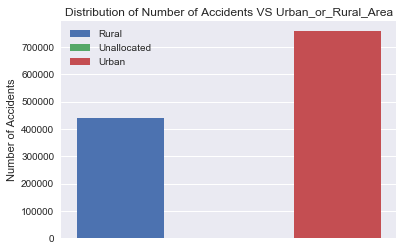

In [77]:
# transform the numerical categorical input to string categorical input
match = {'Urban':1, 'Rural':2, 'Unallocated':3}

dic = dict(train['Urban_or_Rural_Area'].value_counts())
cate = {}
for key, value in match.items():
    cate[key] = dic[value]

for key, value in cate.items():
    plt.bar(key, value, label="%s" %(key))

plt.title("Distribution of Number of Accidents VS %s" %('Urban_or_Rural_Area'))
plt.ylabel ('Number of Accidents')
plt.xticks([])
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
From the plot, we can see in general there are more accidents happened in urban areas. This might be due to denser population and heavier traffic flow in urban area compared to rural areas.
</div>

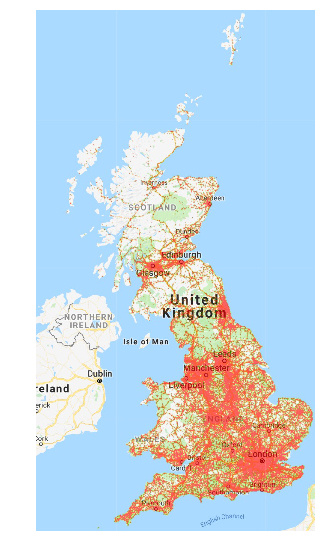

In [78]:
# insert heatmap created for the accident distribution
plt.figure(figsize=(5,25))
img=mpimg.imread('Map_all_in_one.jpg')
imgplot = plt.imshow(img)
plt.grid(False)
plt.axis("Off")
plt.show()

<div class="alert alert-block alert-info">
By plotting the locations of all accidents on the map, we obtained the heatmap above. It indeed shows us there are centralised zones formed around the country which appear to in the city areas. 
</div>

## 1.2 Top 10 Districts with Highest Number of Accidents

In [79]:
area_wise = train.groupby(['Local_Authority_(District)']).size().to_frame('count')

In [80]:
area_wise = area_wise.nlargest(10,'count').reset_index()

In [81]:
# match the district names to the codes
area_wise.insert(2, 'District Name', area_wise['Local_Authority_(District)'].map(district.set_index('code')['label']))

In [82]:
area_wise

,Local_Authority_(District),count,District Name
0,300,24674,Birmingham
1,204,16007,Leeds
2,102,12970,Manchester
3,926,11809,Glasgow City
4,91,10955,Liverpool
5,200,10749,Bradford
6,215,10551,Sheffield
7,1,9694,Westminster
8,601,9179,"Bristol, City of"
9,923,8870,"Edinburgh, City of"


<div class="alert alert-block alert-info">
From the results, we can see the top 10 districts are the relatively developed cities in UK. This again prove our hypothesis that more populated place and heavier traffic flow are likely to lead to accidents happening. Furthermore, from the plots we can see there are actually centralised zones in the distribution for car accidents. Thus, it is meaningful to find the appropriate location to set up emergency department based on the clusters of the centralised zone.
</div>

## 1.3 Cluster Centroids for Accidents

<div class="alert alert-block alert-info">
In the section, we applied KMeans Clustering to find out the 10 centers based on accident locations for further analysis and the centroid to set up the emergency department. 
</div>

 ### 1.3.1 Clustering Based on All Accident Locations

In [83]:
# drop the NAs in coordinates and run KMeans for 10 clusters
# plot the centroids obtained on map 

acc_locations = train.dropna(axis=0, subset=['Latitude','Longitude'])
kmeans0 = KMeans(n_clusters=10, random_state=0).fit(acc_locations[['Latitude', 'Longitude']])

centers0 = kmeans0.cluster_centers_

map = folium.Map(location=[53.5074, -0.1278], zoom_start=6)
for point in range(0, len(centers0)):
    folium.Marker(centers0[point]).add_to(map)
map

<div class="alert alert-block alert-info">
Above is the 10 centers based on **ALL** the accident locations. 
We would like to to further investigate that if the centers for accidents of different severity levels vary. Hence, we carry out KMeans clustering based on locations for each severity level.
</div>

 ### 1.3.2 Clustering Based for Accident Severity 1

In [84]:
# Clustering for Severity 1 Accidents

sev1 = train.loc[train['Accident_Severity']==1]

sev1_locations = sev1.dropna(axis=0, subset=['Latitude','Longitude'])
kmeans1 = KMeans(n_clusters=10, random_state=0).fit(sev1_locations[['Latitude', 'Longitude']])

centers1 = kmeans1.cluster_centers_

map = folium.Map(location=[53.5074, -0.1278], zoom_start=6)
for point in range(0, len(centers1)):
    folium.Marker(centers1[point]).add_to(map)
map

### 1.3.2 Clustering Based for Accident Severity 2

In [85]:
# Clustering for Severity 2 Accidents

sev2 = train.loc[train['Accident_Severity']==2]

sev2_locations = sev2.dropna(axis=0, subset=['Latitude','Longitude'])
kmeans2 = KMeans(n_clusters=10, random_state=0).fit(sev2_locations[['Latitude', 'Longitude']])

centers2 = kmeans2.cluster_centers_
#print(centers)
map = folium.Map(location=[53.5074, -0.1278], zoom_start=6)
for point in range(0, len(centers2)):
    folium.Marker(centers2[point]).add_to(map)
map

 ### 1.3.4 Clustering Based for Accident Severity 3

In [86]:
# Clustering for Severity 3 Accidents

sev3 = train.loc[train['Accident_Severity']==3]

sev3_locations = sev3.dropna(axis=0, subset=['Latitude','Longitude'])
kmeans3 = KMeans(n_clusters=10, random_state=0).fit(sev3_locations[['Latitude', 'Longitude']])

centers3 = kmeans3.cluster_centers_
#print(centers)
map = folium.Map(location=[53.5074, -0.1278], zoom_start=6)
for point in range(0, len(centers3)):
    folium.Marker(centers3[point]).add_to(map)
map

<div class="alert alert-block alert-info">
The centers formed based on accidents locations for accidents of severity level 1, 2 and 3 are mostly similar to each other. These locations are usually the center of the more developed cities such as London, Edinburgh and Birmingham.

Next, we plot the scatter diagram for the accidents to see if the clustering is reasonable. 
</div>

 ### 1.3.5 Cluster-based Scatter Plots

<div class="alert alert-block alert-info">
In this section, we would like to take a closer look at the division of each cluster.
</div>

In [87]:
# Get the coordicates of accidents

# coordinates for ALL accidents
xx0 = list(acc_locations['Longitude'])
yy0 = list(acc_locations['Latitude'])

# coordinates for severity 1 accidents
xx1 = list(sev1_locations['Longitude'])
yy1 = list(sev1_locations['Latitude'])

# coordinates for severity 2 accidents
xx2 = list(sev2_locations['Longitude'])
yy2 = list(sev2_locations['Latitude'])

# coordinates for severity 3 accidents
xx3 = list(sev3_locations['Longitude'])
yy3 = list(sev3_locations['Latitude'])

In [88]:
# Get colours for clusters
num_colours = len(set(kmeans1.labels_))
colors = list(mcolors.CSS4_COLORS.keys())
cluster_colours=np.random.choice(colors, num_colours)

In [89]:
# function to plot the scatter diagrams of coordinates in later section

def plot_map(kmeans_level, centers, x, y):
    x_=[]
    y_=[]
    c_=[]
    
    for l, x, y in zip(kmeans_level.labels_, x, y):
        if l==-1:
            continue
        x_.append(x)
        y_.append(y)
        c_.append(cluster_colours[l])
    #plt.figure(figsize=(18, 12))
    plt.scatter(x_,y_,s=0.5,c=c_)
    plt.scatter(centers[:, 1], centers[:, 0], s=20, c='black')

    plt.xlim(-8,8)
    plt.ylim(50,59)
    plt.figure(figsize=(50,50))
    plt.show()
    

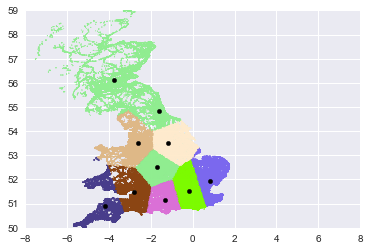

In [90]:
# Scatter plots for all accidents and centroids based on clustering
plot_map(kmeans0, centers0, xx0, yy0)

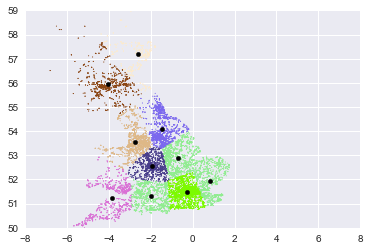

In [91]:
# Scatter plots for severity level 1 accidents and centroids based on clustering
plot_map(kmeans1, centers1, xx1, yy1)

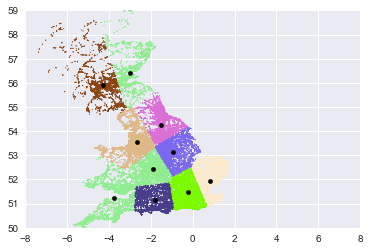

In [92]:
# Scatter plots for severity level 2 accidents and centroids based on clustering
plot_map(kmeans2, centers2, xx2, yy2)

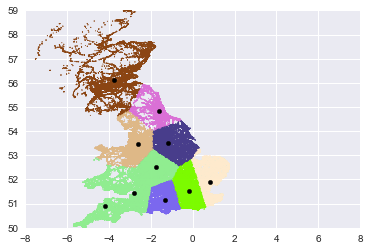

In [93]:
# Scatter plots for severity level 3 accidents and centroids based on clustering
plot_map(kmeans3, centers3, xx3, yy3)

In [94]:
# centroids for clustering results for all clusters
centers0

array([[51.53770112, -0.18235618],
       [53.49036849, -2.61970418],
       [56.11839827, -3.74613639],
       [51.46280453, -2.80268032],
       [52.51879046, -1.72957104],
       [53.49497676, -1.17450554],
       [51.14360857, -1.317415  ],
       [51.92223971,  0.84388881],
       [50.90795469, -4.18770112],
       [54.83835654, -1.62126627]])

## 1.4 Conclusion for Research Question 1

<div class="alert alert-block alert-info">
There are no overlap seen in the clusters. The divison of clusters looks reasonable. The cluster centroids are mostly located at the locations with the high densities of accidents as expected. The clustering for all accidents are highly similar to the one for level 3 accidents, while the clustering for level 1 and 2 accidents are slightly off. This may be because of the skewed distribution of different severity level in the dataset. Generally, the cluster centroids are rather similar for overall and 3 different severity level. These locations could thus be the potential good points for emergency response stations. The cluster that has high density can be prioritised for emergency department set-up.
</div>

# 2. Research Question 2
### What are the common traits among the "more dangerous" locations?

## 2.1 Top 15 Dangerous Places

<div class="alert alert-block alert-info">
Now we move on from districts to exact locations. There are large number of distinct longitude and latitude locations in the dataset, thus, we will first select a reasonable sized sample of it for our further study.
</div>

In [95]:
# create coordinates 
locations = train[['Latitude','Longitude']]
locations['Latitude'] = locations['Latitude'].astype(float)
locations['Longitude'] = locations['Longitude'].astype(float)
locations['coord'] = list(zip(locations['Latitude'],locations['Longitude']))

In [96]:
locations=locations.groupby(locations['coord']).size().to_frame('count')

In [97]:
top50_location = locations.nlargest(50, 'count').reset_index()

In [98]:
top50_location['xlabel']=top50_location.index.values

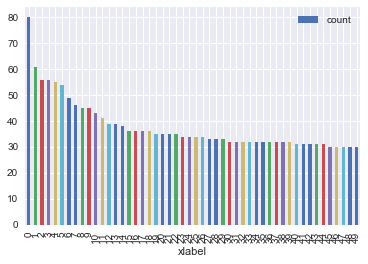

In [99]:
top50_location.plot.bar(x='xlabel', y='count')

<div class="alert alert-block alert-info">
Based on the above plot, we decide to study on the top 15 locations which have more significant numbers of accidents happened. From the 16th location onwards, the number of accidents happening are much less compared to the top 15 locations. 
</div>

In [100]:
top15_location = locations.nlargest(15, 'count').reset_index()

In [101]:
locationlist = [list(i) for i in top15_location['coord']]

In [102]:
# plot the top 15 locations on map

map_1 = folium.Map(location=locationlist[0], zoom_start=6)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map_1)
map_1

<div class="alert alert-block alert-info">
Above are the top 15 locations where the highest number of accidents occured. These locations are mostly at the center of cities and also the intersections of main traffic routes. This can be seen if we zoomed in to the map.
</div>

## 2.2 Possible Common Traits among the Top Locations

### 2.2.1 Road Type

In [103]:
# show the top 1 location on map 
map_1 = folium.Map(location=locationlist[0], zoom_start=15)
folium.Marker(locationlist[0]).add_to(map_1)
map_1

In [104]:
# show the top 2 location on map 
map_1 = folium.Map(location=locationlist[1], zoom_start=15)
folium.Marker(locationlist[1]).add_to(map_1)
map_1

In [105]:
# show the top 3 location on map 
map_1 = folium.Map(location=locationlist[2], zoom_start=15)
folium.Marker(locationlist[2]).add_to(map_1)
map_1

In [106]:
# show the top 4 location on map 
map_1 = folium.Map(location=locationlist[3], zoom_start=15)
folium.Marker(locationlist[3]).add_to(map_1)
map_1

In [107]:
# show the top 5 location on map 
map_1 = folium.Map(location=locationlist[4], zoom_start=14.8)
folium.Marker(locationlist[4]).add_to(map_1)
map_1

<div class="alert alert-block alert-info">
Based on the map shown above, we found 4 out of the top 5 locations are actually at the roundabouts. We would like to see whether roudabouts are prone to accidents. This will be investigated further by looking at the distribution for the top 15 locations found earlier.
</div>

In [108]:
# create dataframe for accidents happened at the top 15 locations 
top15 = pd.DataFrame()
for i, j in locationlist:
    y = df.loc[(df['Latitude']==i) & (df['Longitude']==j)]
    top15 = top15.append(y)

In [109]:
# create new 'Month' columns 
top15['date'] = pd.to_datetime(top15['Date'], format = '%d/%m/%Y')
top15['Month'] = np.array([d.month for d in top15['date']])

In [110]:
# create new 'Hour' column
top15['Time'] = pd.to_datetime(top15['Time'], format='%H:%M')
top15['Hour'] = np.array([d.hour for d in top15['Time']])

In [111]:
# functions created for data visualisation in later sections
# final output will be a dictionary 'allinfo' with keys being coordinates of locations 
# and values being dictionary which has keys of variables and values of counts

def count_accident(coord):
    count = 0
    for i in top15['coord']:
        if i == coord:
            count+=1 
    return count

def get_info(variable, coord):
    lst = list(top15[top15['coord']==coord][variable])
    return lst

In [112]:
variables=list(top15.columns)

In [113]:
top15['coord']= list(zip(top15.Latitude, top15.Longitude))

allinfo = {}
for i in list(set(top15['coord'])):
    allinfo[i]={}
    allinfo[i]['count']=count_accident(i)
    for j in variables:
        allinfo[i][j]=get_info(j,i)

In [114]:
for i in allinfo.values():
    for variable in i.keys():
        if variable != 'count':
            info = i[variable]
            i[variable]={}
            for key in info:
                i[variable][key]=info.count(key)

In [115]:
# function to plot bar charts for different variables
def plot(variable):
    
    types = {}
    for coord in allinfo.keys():
        types[coord]=allinfo[coord][variable]

    typeFrame = pd.DataFrame(types)

    to_plot={}
    for i in list(typeFrame.index):
        count= 0
        for coord in types.keys():
            if i in types[coord].keys():
                count += types[coord][i]
        to_plot[i]=count

    for key, value in sorted(to_plot.items(),key=lambda x: x[1], reverse=True):
        plt.bar(str(key), value, label="%s" %(key))
    plt.xticks([])
    plt.xlabel("%s" %(variable))
    plt.ylabel("Number of Accidents")
    plt.title("Number of Accidents VS %s at the top 15 locations" %(variable))
    plt.legend()
    plt.show()

In [116]:
# create dataframe for accidents of each severity levels
sev1 = top15.loc[top15['Accident_Severity']==1]
sev2 = top15.loc[top15['Accident_Severity']==2]
sev3 = top15.loc[top15['Accident_Severity']==3]

In [117]:
# function to create dictionary which will be used for plotting later 
# var = variable, level = severity level 
# output dictionary has key of different categories of the variable and value of counts of accidents

def create_dic(var, level):
    if level==1:
        c = sev1.groupby(var).size()
    elif level==2:
        c = sev2.groupby(var).size()
    elif level==3:
        c = sev3.groupby(var).size()
    d = c.to_dict()
    return d

In [118]:
# function to plot bar charts of given input variable for each severity level 
def sev_plot(var):
    
    c1 = create_dic(var,1)
    c2 = create_dic(var,2)
    c3 = create_dic(var,3)

    plt.figure(figsize=(15,4))

    f1 = plt.subplot(1,3,1)
    for key, value in sorted(c1.items(),key=lambda x: x[1], reverse=True):
        f1.bar(str(key), value, label="%s" %(key))
    f1.set_title('Severity 1', fontsize=10)
    f1.legend(labels= list(c1.keys()),loc=5)

    f2 = plt.subplot(1,3,2)
    for key, value in sorted(c2.items(),key=lambda x: x[1], reverse=True):
        f2.bar(str(key), value, label="%s" %(key))
    f2.set_title('Severity 2', fontsize=10)
    f2.legend(labels= list(c2.keys()),loc=5)


    f3 = plt.subplot(1,3,3)
    for key, value in sorted(c3.items(),key=lambda x: x[1], reverse=True):
        f3.bar(str(key), value, label="%s" %(key))
    f3.set_title('Severity 3', fontsize=10)
    f3.legend(labels= list(c3.keys()),loc=5)

    plt.tight_layout()
    plt.show()

In [119]:
# function to plot bar charts for 

def population(x):
    
    dic = dict(df[x].value_counts())
    
    for key, value in sorted(dic.items(),key=lambda x: x[1], reverse=True):
        plt.bar(str(key), value, label="%s" %(key))
        
    plt.title("Number of Accidents VS %s" %(x))
    plt.xlabel (x)
    plt.ylabel ('Number of Accidents')
    plt.xticks([])
    plt.legend()
    plt.show()
    

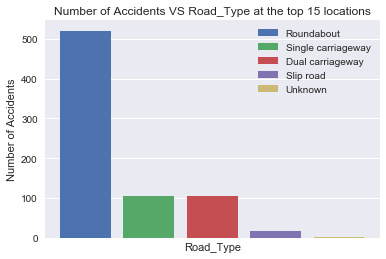

In [120]:
plot('Road_Type') # for top 15 locations

<div class="alert alert-block alert-info">
Indeed, the majority of accidents happened at the top 15 locations are at roundabout. While in the overall record of accidents, we have the single carriageway as our major road type as shown below. This suggests the high number of accidents occuring at roundabout for the top 15 locations are not due to the large number of cases belonging to roundabout in the overall data. Rather, this shows us that roundabout is indeed conducive to incidents.
</div>

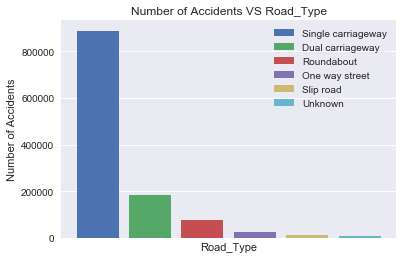

In [121]:
population('Road_Type') # for all locations

### 2.2.2 Speed Limit

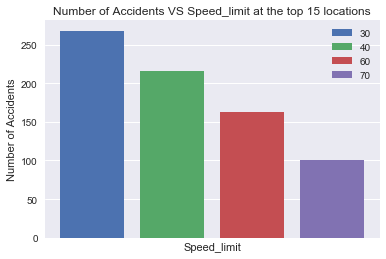

In [122]:
plot('Speed_limit') # for top 15 locations

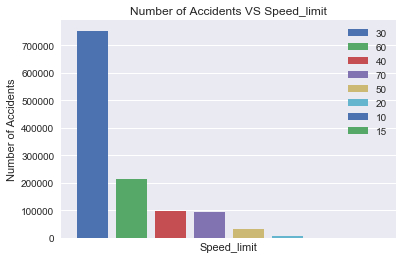

In [123]:
population('Speed_limit') # for all locations

<div class="alert alert-block alert-info">
The percentage of accidents happening in a road with higher speed limit (60, 70) in the top 15 locations are much larger than that for all cases. Thus, this suggests having higher speed limit may be the reason why these places are dangerous and more 'prone' to accidents.
</div>


## 2.3 Conclusion for Research Question 2

<div class="alert alert-block alert-info">
In general, roads with high speed limit and are located at the roundabouts are more likely to be the more dangerous place. Thus, when having road planning, the officers should avoid use roudabouts or set lower speed limit when the road type is roudabout.
</div>

# 3. Research Question 3
## Are there certain times of the year that are more conducive to incidents?

## 3.1 Decomposing for Time Series Data

<div class="alert alert-block alert-info">
In this section, we have decomposed one year data in trend, seasonality and residual to investigate any viscible patterns in the dataset. We have only chosen one year data as using too much data points makes the seasonality plot hard to tell the pattern.
</div>

In [124]:
df_by_month = df.groupby("date").size().to_frame().sort_index()

In [125]:
df_by_month.head()

,0
date,
2005-01-01,637
2005-01-02,636
2005-01-03,618
2005-01-04,979
2005-01-05,1096


In [126]:
# do it for 2005 only as seasonality plot is too 'busy' to see any lines
df_by_month = df_by_month.loc[df_by_month.index<datetime.strptime('2006', "%Y")]

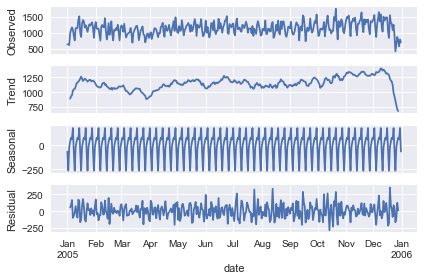

In [127]:
result = seasonal_decompose(df_by_month, model='additive')
result.plot()
plt.show()

<div class="alert alert-block alert-info">
From our decomposition of monthly accident counts, we can see that there is seasonailty. As the cycle appears to be rather frequent (e.g. more frequent than 12), we can thus deduce that seasonality occurs not in months but weeks.
</div>

## 3.2 Accidents by Week

<div class="alert alert-block alert-info">
In this section, we would like to zoom into the week level so as to observe the pattern for number of accidents occuring over a week.
</div>

In [128]:
df_y2005 = df.copy()
df_y2005 = df_y2005.loc[df_y2005['date'] < datetime.strptime('2006', '%Y')]

In [129]:
df_y2005=df_y2005.sort_values(["date","Day_of_Week"], ascending=[True, True])
df_y2005[["date","Day_of_Week"]].head()

,date,Day_of_Week
768,2005-01-01,7
1787,2005-01-01,7
1790,2005-01-01,7
1791,2005-01-01,7
1801,2005-01-01,7


In [130]:
# if my previous day of week is not 7 and my current day of week is 7, increase week number
week_numbers = {"week_number": []}
current_week = 1
prev_day = df_y2005.Day_of_Week.iloc[0]

for i in range(len(df_y2005.index)): 
    current_day = df_y2005.Day_of_Week.iloc[i]
    
    # if my previous day of week is not 7 and my current day of week is 7, increase week number
    if (prev_day!=7) & (current_day==7):
        current_week += 1
    
    # current day will become previous day
    prev_day = current_day
    week_numbers['week_number'].append(current_week)

df_y2005['week_number'] = week_numbers['week_number']

In [131]:
h = df_y2005.groupby(['week_number', 'Day_of_Week']).size().to_frame(name='count').reset_index()
h.head()

,week_number,Day_of_Week,count
0,1,1,636
1,1,2,618
2,1,3,979
3,1,4,1096
4,1,5,1173


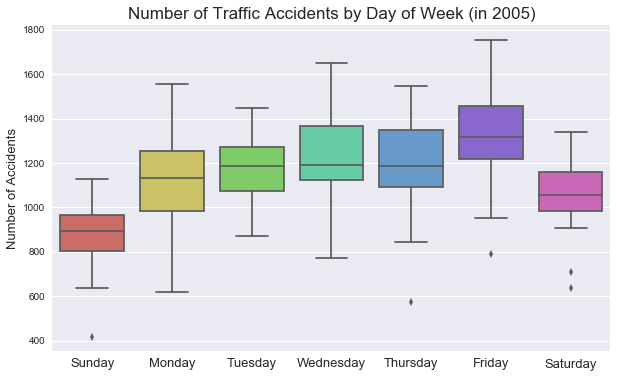

In [132]:
sevenColorPalette = sns.color_palette('hls', 7) # 

# Plot boxplot showing number of accidents by day of week in 2005
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.boxplot(x='Day_of_Week', y='count', data=h, 
            palette=sevenColorPalette)

# Define x_axis for xticks
x_axis = np.arange(0,7,1)
plt.xticks(x_axis, ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'), fontsize=13)

plt.xlabel('')
plt.ylabel('Number of Accidents', fontsize=13)

plt.title('Number of Traffic Accidents by Day of Week (in 2005)', fontsize=17)
plt.show()

<div class="alert alert-block alert-info">
From the the above box plots, we can tell during week day the average number of accidents happening are much higher than that for weekends. While for Monday and Friday, the number of accidents happening vary quite largely. This might be due to the fact that people tend to take long weekends, thus number of people going for work varies largely on Monday and Friday.
<br>
<br>
We would like to take one month worth of data (January) and plot out the the days of each week to validate the pattern shown above where weekdays have much higher number of accidents happening.
</div>

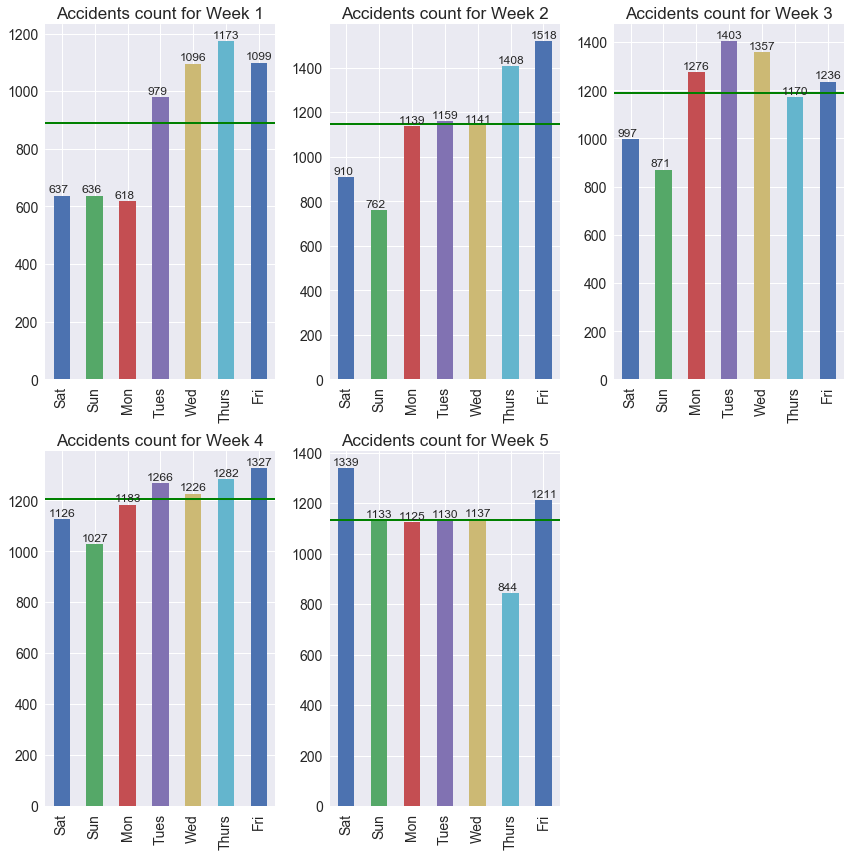

In [133]:
# we take a subset - 1st month data
# 5 plots for 5 weeks of data 
# count number of accidents by date for each week number
xt = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri']

df_each_week = df_y2005.loc[df_y2005['week_number']==5].groupby('Date').size()
plt.figure(figsize=(12,12))

for i in range(1,6) :
    df_each_week = df_y2005.loc[df_y2005['week_number']==i].groupby('Date').size()
    
    ax = plt.subplot(2,3,i)
    df_each_week.plot('bar', fontsize=14)
    ax.set_title("Accidents count for Week %d" %i, fontsize=17)
    ax.axhline(df_each_week.mean(), color='green', linewidth=2)
    plt.setp(ax, xticks=[0,1,2,3,4,5,6], xticklabels=xt)
    ax.set_xlabel('')
    labs = df_each_week.values
    
    for i in range(0,7):
        plt.text(x=i-0.4, y=df_each_week.values[i]+12, s=labs[i], size=12)

plt.tight_layout()

<div class="alert alert-block alert-info">
The above plots is the first 5 weeks distribution for 2005. The green line in the plot is the average number of accidents happening each day for that week. For most weeks, the number of accidents on weekdays above the average line. The pattern which we identified in the previous Box plot is thus supported.
</div>

## 3.3 Trends in Weekdays 

<div class="alert alert-block alert-info">
We would like to further find out what are the factors during week day that have more number of accidents happening. By looking at all the factors, it is found that peak vs non-peak hours, urban vs rural area and certain geographical locations are the main factors.
</div>

### 3.3.1 Peak vs Non-Peak hours

<div class="alert alert-block alert-info">
Firstly, let's look at the number of accidents happening per hour during peak hours versus that for non peak hours. Peak hours here are defined as `7:30am to 9:30am` and `17:00 to 19:00`.
</div>

In [134]:
# get data for each of the weekdays
df_mon = df_y2005.loc[(df_y2005['week_number']<6) & (df_y2005['Day_of_Week']==2)]
df_tues = df_y2005.loc[(df_y2005['week_number']<6) & (df_y2005['Day_of_Week']==3)]
df_wed = df_y2005.loc[(df_y2005['week_number']<6) & (df_y2005['Day_of_Week']==4)]
df_thurs = df_y2005.loc[(df_y2005['week_number']<6) & (df_y2005['Day_of_Week']==5)]
df_fri = df_y2005.loc[(df_y2005['week_number']<6) & (df_y2005['Day_of_Week']==6)]

days_lst = [df_mon,df_tues,df_wed,df_thurs,df_fri]

In [135]:
# count number of accidents for each day for 
# 1) 07:30 to 09:30, and 
# 2) 17:00 to 19:00

# helper function to plot average number of accidents during Peak and Non-Peak hours on a weekday
def plot_PK_NPK(df_day, day_of_week):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day = weekdays[day_of_week-1]
    pk_counts = 0
    npk_counts = 0

    for i in range(len(df_day.index)):
        # count for morning peak hours
        if (df_day.iloc[i,]['Time']>=datetime.strptime('07:30',"%H:%M") ) & (df_day.iloc[i,]['Time']<=datetime.strptime('09:30',"%H:%M") ):
            pk_counts += 1
        
        # evening peak hours
        elif (df_day.iloc[i,]['Time']>=datetime.strptime('17:00',"%H:%M") ) & (df_day.iloc[i,]['Time']<=datetime.strptime('19:00',"%H:%M")):
            pk_counts += 1

        # count for non-peak hours
        else:
            npk_counts += 1

    total_pk_hours = 6
    total_npk_hours = 18
    height=[round(pk_counts/total_pk_hours, 2), round(npk_counts/total_npk_hours, 2)] 

    # plot the averages per day    
    ax = fig.add_subplot(2,3,day_of_week)
    ax.bar(x=['Peak', 'Non-peak'], 
           height=height, # average number of accidents happening during pk and npk
           color=['red', 'blue'], 
           align='center')
    ax.set_title("Peak vs Non-Peak hours on %s" %day, fontsize=15)
    ax.set_ylabel("Average Number of Accidents")
    
    # set Text on the top of each barplot
    for i in range(0,len(height)):
        plt.text(x=i-0.1, y=height[i]+2, s=height[i], size=14)
    
    fig.tight_layout()

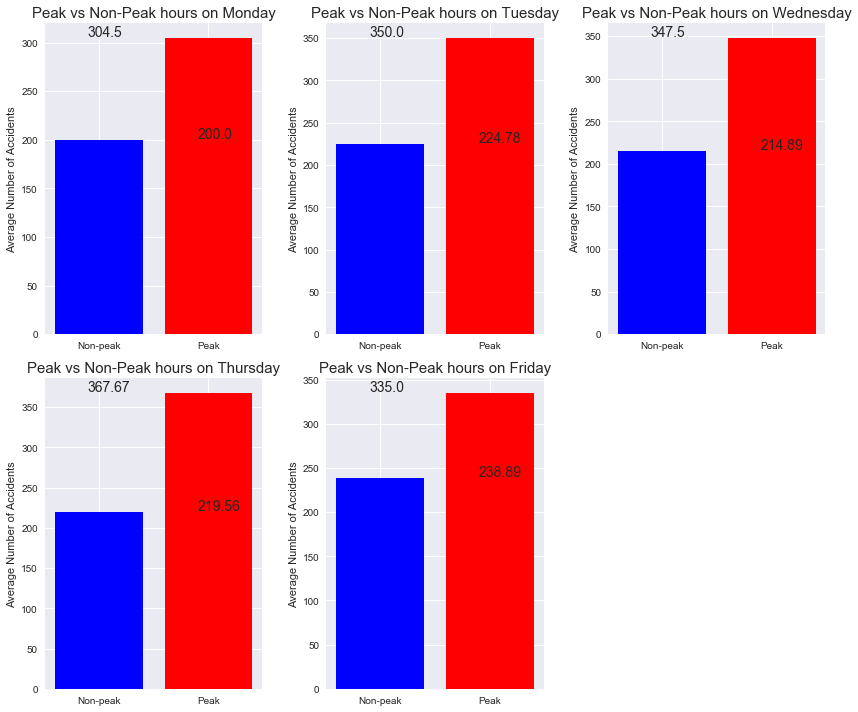

In [144]:
fig = plt.figure(figsize=(12,10))

for i in range(1, len(days_lst)+1):
    plot_PK_NPK(days_lst[i-1], i)

<div class="alert alert-block alert-info">
From the plots, we see that on average, the number accidents happening during *Peak hours* is higher than that of *Non-Peak hours*. To verify what we saw in the previous plots, let's plot Peak vs Non-Peak by the time of each hour.
</div>

In [137]:
# helper function to plot PK/non-PK by hours 
def plot_PK_NPK_24hours(df_day, day_of_week):
    colors = []
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day = weekdays[day_of_week-1]
    
    # get number of accidents occuring in each hour 
    df_hour = df_day.groupby('Hour').size().to_frame().reset_index()
    
    # we specify the colors of each bar by the hour they are in
    # peak hour - red
    # non-peak hour - blue
    for i in range(len(df_hour.index)): 
        if (df_hour['Hour'].iloc[i]>7) & (df_hour['Hour'].iloc[i]<10):
            colors.append('red')
        elif (df_hour['Hour'].iloc[i]>=17) & (df_hour['Hour'].iloc[i]<=19):
            colors.append('red')
        else:
            colors.append('blue')
            
    
    ax = fig.add_subplot(2,3,day_of_week)
    ax.bar(x=df_hour.index, height=df_hour.values[:,1], color=colors, align='center')
    ax.set_title("Peak hours vs Non-peak hours on a %s" %day, fontsize=15)
    ax.set_ylabel("Number of Accidents")
    
    # codes needed to specify legend labels based on colors 
    red_patch = mpatches.Patch(color='red')
    blue_patch = mpatches.Patch(color='blue')
    
    ax.legend(loc='best', handles=[red_patch, blue_patch], labels=("Peak Hours", "Non-Peak Hours"))
    fig.tight_layout()

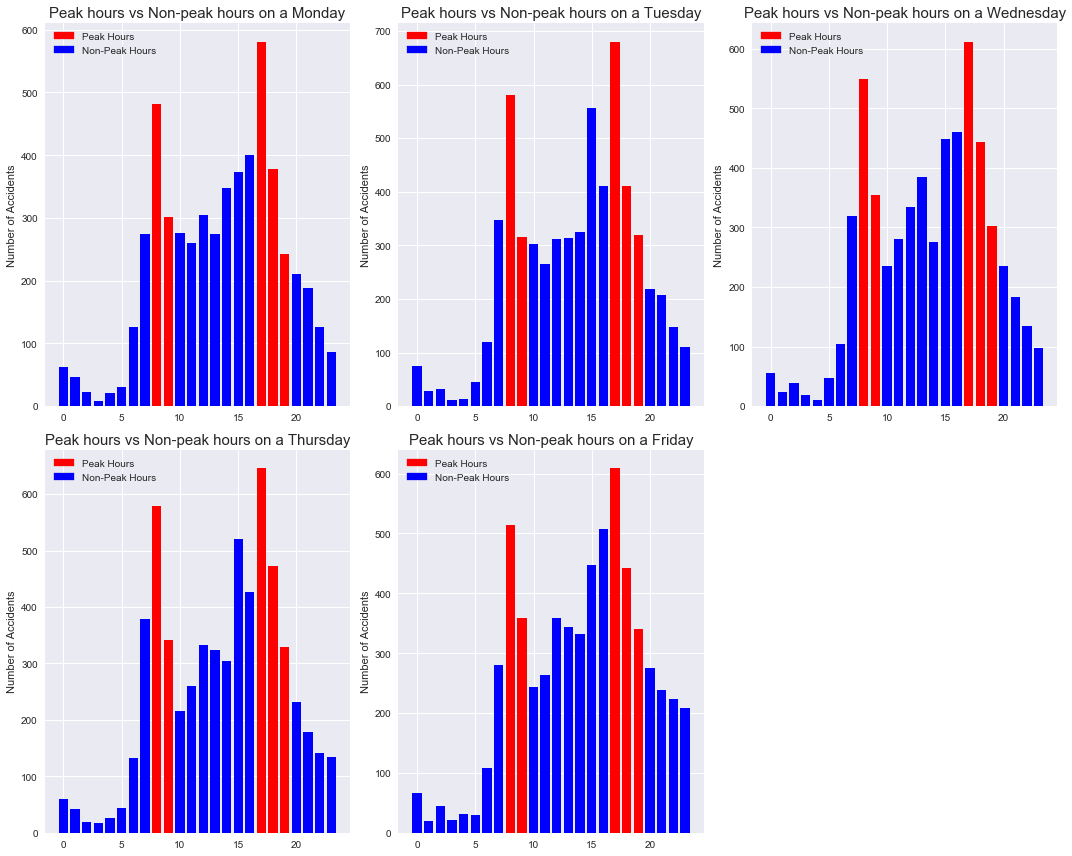

In [138]:
# create main plot to store all subplots
fig = plt.figure(figsize=(15,12))

# iterate every weekdays and plot the distribution
for i in range(1, len(days_lst)+1):
    plot_PK_NPK_24hours(days_lst[i-1], i)

<div class="alert alert-block alert-info">
From the detailed breakdown, it is easily noticed that during peak hours, there are a spike for number of accidents happening. 
</div>

### 3.3.2 Urban vs Rural Areas

<div class="alert alert-block alert-info">
Let's then look at the second contributing factor which is urban vs rural areas.
</div>

In [139]:
def plot_UB_RR(df_day, day_of_week):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    day = weekdays[day_of_week-1]
    urban_counts = 0
    rural_counts = 0
    total_accident_counts = len(df_day.index)

    for i in range(len(df_day.index)): 
        current = df_day.iloc[i,]
        if current.Urban_or_Rural_Area == 1:
            urban_counts+=1

        elif current.Urban_or_Rural_Area == 2:
            rural_counts+=1
    
    height=[round(urban_counts/total_accident_counts*100, 2), round(rural_counts/total_accident_counts*100, 2)]
    
    ax = fig.add_subplot(2,3,day_of_week)
    ax.bar(x=['Urban', 'Rural'], 
           height=height,
           align='center', color=['red', 'blue'])
    ax.set_title("Urban vs Rural areas on %s" %day, fontsize=15)
    ax.set_ylabel("Number of Accidents")
    
    # set Text on the top of each barplot
    for i in range(0,len(height)):
        plt.text(x=i-0.1, y=height[i]+0.5, s=str(height[i])+'%', size=14)
    
    fig.tight_layout()

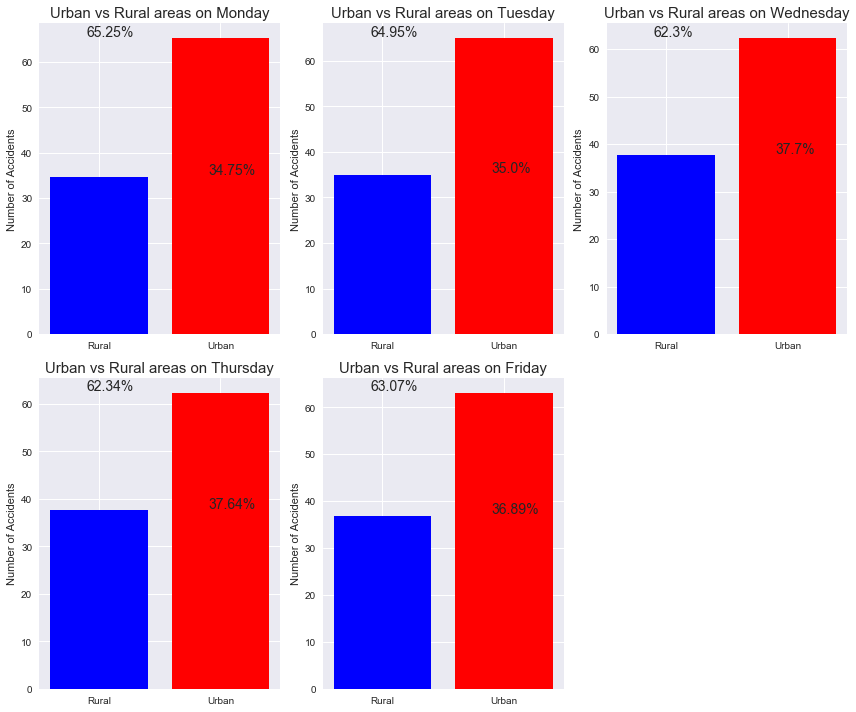

In [140]:
fig = plt.figure(figsize=(12,10))

for i in range(1, len(days_lst)+1):
    plot_UB_RR(days_lst[i-1], i) 

<div class="alert alert-block alert-info">
We see that the proportion of accidents happening in Urban areas are higher than that of Rural areas. This might be due to urban areas are more densely populated.
</div>

### 3.3.3 Visualising the Accident Locations in Urban area

<div class="alert alert-block alert-info">
Since we know accidents tend to occur in *Urban* areas, one might wonder which parts of the cities are they clustered in. In this case, we have looked at London as an example to find out the potential areas in urban place that have higher number of accidents happening.
</div>

In [141]:
# Gather all the weekdays accident location's lat and long
locations = df_mon[['Latitude', 'Longitude']]
for i in range(1, len(days_lst)):
    locations = locations.append(days_lst[i][['Latitude', 'Longitude']])

locations['Latitude'] = locations['Latitude'].astype(float)
locations['Longitude'] = locations['Longitude'].astype(float)
locations.dropna(inplace=True)# drop those unknown lat and long
locationlist = locations.values.tolist()

In [142]:
# For simplicity purposes, we shall filter lat and lon to London area only 51.509865, -0.118092
# North bound 51.685862, -0.033119
# East bound 51.620791, 0.306797
# South bound 51.280284, -0.081612
# West bound 51.510752, -0.595178

north = 51.685862
south = 51.280284
west = -0.595178
east = 0.306797

f = locations[(locations['Latitude'] > south) & (locations['Latitude'] < north)]
f = f[(f['Longitude'] > west) & (f['Longitude'] < east)]

# change lat and long dataframe to a list of list and sort them
flist = f.values.tolist()
flist = sorted(flist, key=lambda x:x[0])

In [143]:
# Create a map with starting focus on London area
map_london = folium.Map(location=[51.507262, -0.127798], zoom_start=12)

# Plot accident locations on the map
HeatMap(flist, radius=10, blur=3).add_to(map_london)

map_london

<div class="alert alert-block alert-info">
We can see that accident hotspots are happening at `shopping districts`, `travel hubs` and `tourist areas` rather than central business districts.
</div>

## 3.4 Conclusion for Research Question 3

<div class="alert alert-block alert-info">
From our findings, we see that during `weekdays`, in particular during the morning, evening `peak hours` where people are travelling to and from work and in urban area, accidents are more prone to happen.  More specifically, the more common places for accidents to happen in urban area on a weekday are shopping districts such as Oxford, travel hubs and Tourist areas. These factors all suggest high traffic flow. Hence, having high traffic flow is the potential reason for accidents to happen. 
</div>